In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

#### Visualizing Dataset

In [2]:
dataset = {}

#training over 1000 data points
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

#testing over 1000 data points
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)


Text(0.5, 1.0, 'Training Data')

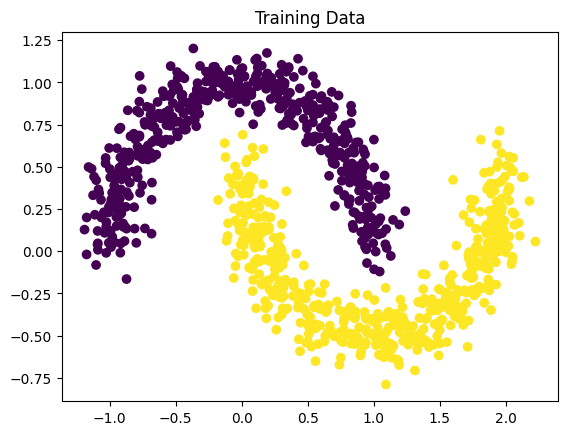

In [3]:
dataset['train_input'] = torch.from_numpy(train_input).float()
dataset['train_label'] = torch.from_numpy(train_label[:, None]).float()
dataset['test_input'] = torch.from_numpy(test_input).long()
dataset['test_label'] = torch.from_numpy(test_label[:, None]).long()



X = dataset['train_input']
y = dataset['train_label']

x = dataset['test_input']
Y = dataset['test_label']

plt.scatter(X[:,0],X[:,1],c=y[:])
plt.title('Training Data')

### QKAN

In [4]:
def generate_knot_vector_uniform(grid_points, control_points, degree):
    
    """
    Function : Generates uniform knot vector
    
    Parameters:
    grid_points (int): length of the knot vector
    control_points (array): array of control points for the knot vector
    degree (int): degree of B-Spline function
    
    Returns:
    tensor : Uniform Knot Vector with points between 0 and 2
    """
    
    min_grid_points = degree + len(control_points) + 1
    if grid_points < min_grid_points:
        raise ValueError(f"Number of grid points must be at least {min_grid_points}")
    knots = np.linspace(0, 2, grid_points)
    return torch.tensor(knots,dtype=torch.float32)


def cox_de_boor(x, i, degree, t):
    
    """
    Function : Recursive Cox De-Boor Algorithm for the basis of B-Spline
    
    Parameters:
        x (int): a knot vector point where basis (N_{i,j}(t)) is to be calculated
        i (int): a control point where basis (N_{i,j}) is to be calculated
        degree (int): degree of B-Spline function (j in N_{i,j})
        t (tensor): uniform knot vector
    
    Returns:
        tensor : Basis functions (N_{i,j}(t)) for B-Spline function
    """
    
    if degree == 0:
        return torch.where((t[i] <= x) & (x < t[i+1]), torch.tensor(1.0,dtype=torch.float32), torch.tensor(0.0,dtype=torch.float32))
    else:
        j = degree
        coeff1 = (x - t[i])/(t[i+j] - t[i]) if (t[i+j] != t[i]) else torch.tensor(0.0,dtype=torch.float32)
        coeff2 = (t[i+j+1] - x)/(t[i+j+1] - t[i+1]) if (t[i+j+1] != t[i+1]) else torch.tensor(0.0,dtype=torch.float32)
        
        return coeff1 * cox_de_boor(x,i,degree-1,t) + coeff2 * cox_de_boor(x,i+1,degree-1,t)
        
        
class BsplineLayer(nn.Module):
    
    def __init__(self,control_points,degree,grid_points):
        super().__init__()
        self.control_points = nn.Parameter(control_points)  #Defining control_points as a Parameter tensor in Parameter class
        self.degree = degree
        self.grid_points = grid_points
        self.knots = generate_knot_vector_uniform(self.grid_points,self.control_points,self.degree) 
        self.scale_factor = nn.Parameter(torch.rand(1, dtype=torch.float32))
        
    def forward(self,x):
        basis_sum = sum(self.control_points[i] * cox_de_boor(x,i,self.degree,self.knots) for i in range(len(self.control_points)))
        scaled_basis_sum = torch.sigmoid(self.scale_factor) * basis_sum  # Ensure scale factor is between 0 and 1
        return scaled_basis_sum
        

##### 2 input BSpline layers + 1 output Bspline Layer

In [5]:
class KAN(nn.Module):
    
    def __init__(self,degree,grid_points):
        super().__init__()
        self.degree = degree
        self.grid_points = grid_points
        
        self.control_points_1 = nn.Parameter(torch.randn(10, dtype=torch.float32))
        self.control_points_2 = nn.Parameter(torch.randn(10, dtype=torch.float32))
        self.control_points_3 = nn.Parameter(torch.randn(10, dtype=torch.float32))
        
        self.bspline_layer_1 = BsplineLayer(self.control_points_1,self.degree,self.grid_points)         # 1 BSpline Layer
        self.bspline_layer_2 = BsplineLayer(self.control_points_2,self.degree,self.grid_points)         # 1 BSpline Layer
        self.bspline_layer_3 = BsplineLayer(self.control_points_3,self.degree,self.grid_points)         # 1 Bspline Layer
        
        self.output_layer = nn.Linear(in_features=1,out_features=2)  #Output layer for classification   #final output Layer
        
        
    def forward(self,x1,x2):
        
        '''
        KAN Layer 1 : 2 BSpline layers taking 2 inputs
        Adding the previous 2 BSpline Layers
        KAN Layer 2 : 1 Bspline layer giving output
        '''
        y1 = self.bspline_layer_1(x1)
        y2 = self.bspline_layer_2(x2)
        
        y = y1+y2
        
        bspline_output = self.bspline_layer_3(y)
        output = self.output_layer(bspline_output.unsqueeze(-1))  # Ensure output is 2D for classification
        return output
    
    
def train_model(model, X, y, criterion, optimizer, num_epochs=1000):
        
    correct_predictions = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        x1 = torch.tensor(X[:,0])
        x2 = torch.tensor(X[:,1])
        target = y.squeeze().long()
        
        outputs = model(x1, x2)
        loss = criterion(outputs, target)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs,1)  #_ = max score ; predicted = class predicted at the end layer
        correct = (predicted == target).sum().item()
        correct_predictions.append(correct)
            
    return correct_predictions           
           

/tmp/ipykernel_31886/1963889514.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(X[:,0])
/tmp/ipykernel_31886/1963889514.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(X[:,1])
/home/akashm/mambaforge/envs/qc/lib/python3.11/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally

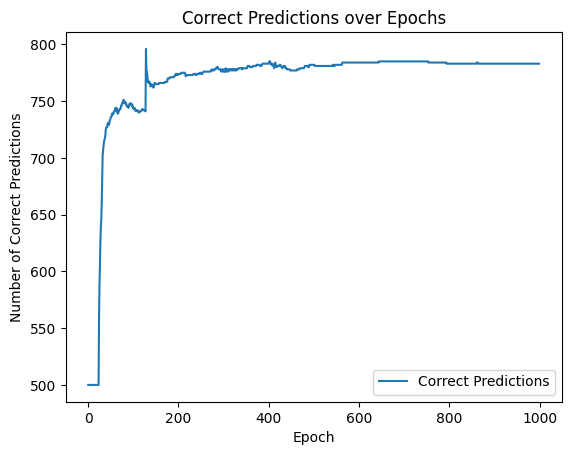

In [6]:
#Solving the model for the example dataset

#Initializing model, criterion and optimizer
degree = 3
grid_points = 14
model = KAN(degree,grid_points)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


#Train the model and get correct predictions
correct_predictions = train_model(model,X,y,criterion,optimizer,num_epochs=1000)

#plot the number of correct predictions over epochs
plt.plot(correct_predictions, label='Correct Predictions')
plt.xlabel('Epoch')
plt.ylabel('Number of Correct Predictions')
plt.title('Correct Predictions over Epochs')
plt.legend()
plt.show()



In [ ]:
# #Test the model
# model.eval()
# with torch.no_grad():
#     x1 = x[:,0]
#     x2 = x[:,1]
#     target = Y.squeeze().long()
#     outputs = model(x1,x2)
#     _,predicted = torch.max(outputs,1)
#     correct = (predicted == target).sum().item()
#     correct_predictions.append(correct)
    
# plt.plot(correct_predictions)

##### 10 input BSpline Layers + 5 Bspline Layers + 1 output BSpline Layer

In [8]:
class KAN(nn.Module):
    
    def __init__(self, degree, grid_points):
        super().__init__()
        self.degree = degree
        self.grid_points = grid_points
        
        self.control_points_x1 = nn.ParameterList([nn.Parameter(torch.randn(10, dtype=torch.float32)) for _ in range(5)])
        self.control_points_x2 = nn.ParameterList([nn.Parameter(torch.randn(10, dtype=torch.float32)) for _ in range(5)])
        self.control_points_layer2 = nn.ParameterList([nn.Parameter(torch.randn(10, dtype=torch.float32)) for _ in range(5)])
        self.control_points_finallayer = nn.Parameter(torch.randn(10, dtype=torch.float32))
        
        self.bspline_layer_x1 = nn.ModuleList([BsplineLayer(cp, self.degree, self.grid_points) for cp in self.control_points_x1])
        self.bspline_layer_x2 = nn.ModuleList([BsplineLayer(cp, self.degree, self.grid_points) for cp in self.control_points_x2])
        self.bspline_layer2 = nn.ModuleList([BsplineLayer(cp, self.degree, self.grid_points) for cp in self.control_points_layer2])
        self.bspline_finallayer = BsplineLayer(self.control_points_finallayer, self.degree, self.grid_points)
        
        self.output_layer = nn.Linear(in_features=1, out_features=2)
        
    def forward(self, x1, x2):
        
        #Input 10 BSpline Layers. 5 BSplines for each input
        y1 = [layer(x1) for layer in self.bspline_layer_x1]
        y2 = [layer(x2) for layer in self.bspline_layer_x2]
        
        #2nd layer with 5 BSplines
        y = [layer(y1[i] + y2[i]) for i,layer in enumerate(self.bspline_layer2)] 
        
        #Final Output Layer
        y_sum = sum(y)
        bspline_output = self.bspline_finallayer(y_sum)
        
        output = self.output_layer(bspline_output.unsqueeze(-1))    #Ensure output is 2D for classification by adding a dimension
        return output
    

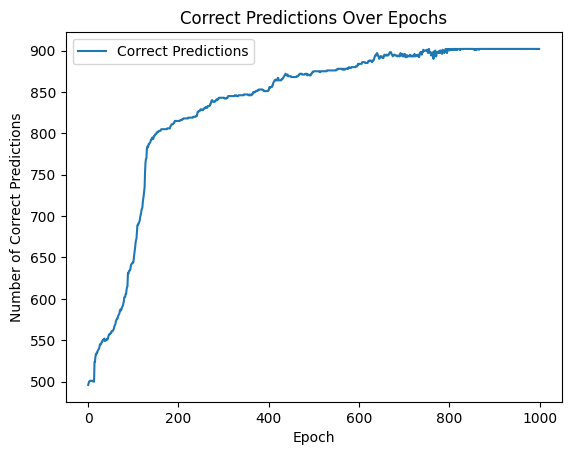

In [10]:
def train_model(model, X, y, criterion, optimizer, num_epochs=1000):
        
    correct_predictions = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        x1 = X[:,0]
        x2 = X[:,1]
        target = y.squeeze().long()
        
        outputs = model(x1, x2)
        loss = criterion(outputs, target)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs,1)  #_ = max score ; predicted = class predicted at the end layer
        correct = (predicted == target).sum().item()
        correct_predictions.append(correct)
            
    return correct_predictions     

# # Example dataset
# dataset = {}
# train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
# test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

# dataset['train_input'] = torch.from_numpy(train_input).float()
# dataset['test_input'] = torch.from_numpy(test_input).float()
# dataset['train_label'] = torch.from_numpy(train_label[:, None]).long()
# dataset['test_label'] = torch.from_numpy(test_label[:, None]).long()

# X = dataset['train_input']
# y = dataset['train_label']

# Initialize model, criterion and optimizer
degree = 3
grid_points = 14
model = KAN(degree, grid_points)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model and get correct predictions
correct_predictions = train_model(model, X, y, criterion, optimizer, num_epochs=1000)

# Plot the number of correct predictions over epochs
plt.plot(correct_predictions, label='Correct Predictions')
plt.xlabel('Epoch')
plt.ylabel('Number of Correct Predictions')
plt.title('Correct Predictions Over Epochs')
plt.legend()
plt.savefig('correct_predictions_over_epochs.png', dpi=600)
plt.show()